<a href="https://colab.research.google.com/github/JaccoVeldscholten/SmartDispenser/blob/main/BAVA_API_Insights_Prediction_TVOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
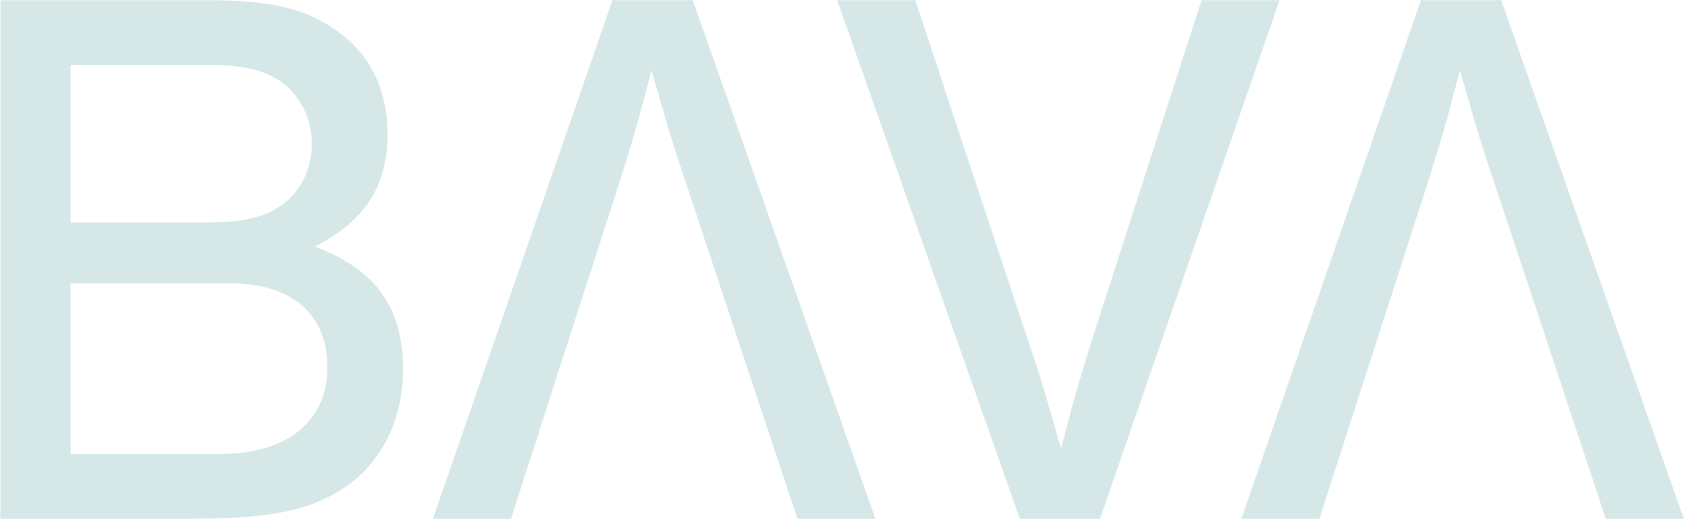
</div>

**API Validation & Prediction** <br>
This document will be validate the gathered API Data and will is able to being used for predictions and analyses

***Temperature Prediction*** <br>
To start off Machine Learning is being used to predict the temperature of the certain amount of days in the toilet. By using basic regression model (linear) its possible to predict the temperature based on the API data thats being generated by the device.

# Imports <br>
In the first stage of the notebook all imports should be made for running the code later on in the notebook

In [26]:
import urllib.request
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import datetime

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# Disable copy warn
pd.options.mode.chained_assignment = None  # default='warn'

2.7.0


# Fetching API <br>
First gather the API Data from the URL. After that print the first elements of the fetched data

In [27]:
with urllib.request.urlopen("https://us-central1-bava-solutions.cloudfunctions.net/GetLogsOfADevice/.F0:08:D1:D8:07:D4") as url:
    data = json.loads(url.read().decode())

In [28]:
df = pd.DataFrame(data)
df.tail()
# df['timestamp'][0]

,mac,batteryLevel,altitude,pressure,temp,tvoc_co2,tvoc_ppm,hum,liquidLevel,occupied,timestamp
120,F0:08:D1:D8:07:D4,100,-152,103098,23,405,0,44,100,False,"{'_seconds': 1639594946, '_nanoseconds': 83100..."
121,F0:08:D1:D8:07:D4,100,-152,103099,23,400,0,44,100,False,"{'_seconds': 1639594947, '_nanoseconds': 39800..."
122,F0:08:D1:D8:07:D4,100,-153,103115,23,402,0,51,100,False,"{'_seconds': 1639595548, '_nanoseconds': 61700..."
123,gshshshshsh,25,100,-1,14,200,29,90,-1,True,"{'_seconds': 1639603953, '_nanoseconds': 10700..."
124,svgssg,50,-1,-1,29,5,5,10,10,False,"{'_seconds': 1639603964, '_nanoseconds': 35600..."


# Plotting the data

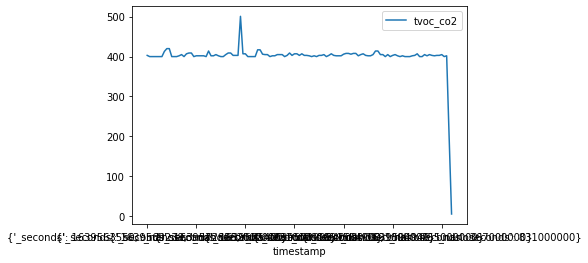

In [29]:
df.plot(x='timestamp', y='tvoc_co2')

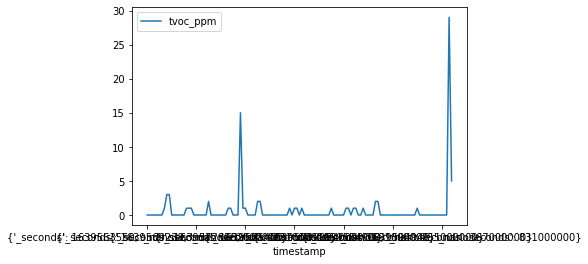

In [30]:
# Reading TVOC
df = pd.DataFrame(data)
df.plot(x='timestamp', y='tvoc_ppm')

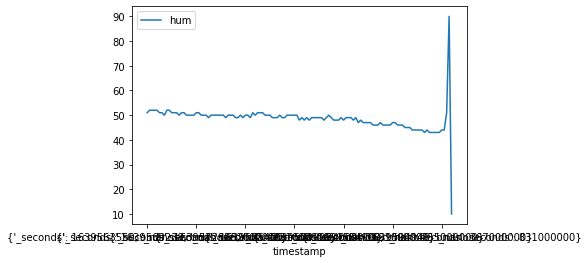

In [31]:
# Reading humidty
df.plot(x='timestamp', y='hum')

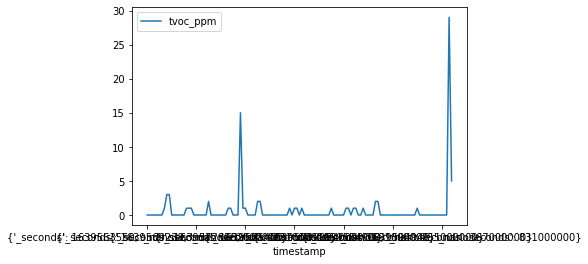

In [32]:
# Reading tvoc_ppmerature
df.plot(x='timestamp', y='tvoc_ppm')

# The numbers mason <br>
The numbers mason what do they mean?

In [33]:
# Getting all triggers by occupation
triggerd_by_occupation = df[df['occupied']==1]
triggerd_by_occupation.count()['occupied']

34

In [34]:
# Getting all triggers by timer
triggerd_by_timer = df[df['occupied']==0]
triggerd_by_timer.count()['occupied']

91

# Predictions <br>
**Predictions based on Machine learning data**<br> 
First prediction is determining what the temperature might be in a few days.


In [35]:
# Tensorflow
np.set_printoptions(precision=3, suppress=True)

#Clean the data. Drop any columns with missing values or null values.

dropping timestamp and mac because they are categorical and irrelevant.

dropping batterylevel and waterlevel because they all have same data.

In [36]:
dataset = df.copy()
dataset.isna().sum()

#dataset.dropna()
cleaned_dataset = dataset.drop(['mac', 'batteryLevel', 'liquidLevel', 'occupied'], axis=1)


tvoc_ppm = cleaned_dataset

for i in range(len(cleaned_dataset['timestamp'])):
  cleaned_dataset['timestamp'][i] = datetime.datetime.utcfromtimestamp((cleaned_dataset['timestamp'][i]['_seconds']) ).strftime('%Y-%m-%d')

cleaned_dataset.index = pd.to_datetime(cleaned_dataset['timestamp'])
cleaned_dataset = cleaned_dataset[cleaned_dataset['temp'] != 0]
cleaned_dataset = cleaned_dataset.drop(['timestamp'], axis=1)
#cleaned_dataset


#Splitting for regression using Tensorflow

In [37]:

train_data = cleaned_dataset.sample(frac=0.5, random_state=0)

test_data = cleaned_dataset.sample(frac=0.2, random_state=0)

# test_data

# cleaned_dataset = cleaned_dataset.drop(['timestamp'], axis=1)

# train_data, test_data = np.split(cleaned_dataset, [int(.3 *len(data))])

train_data
print(len(test_data), len(train_data), len(cleaned_dataset))

# Y = cleaned_dataset['tvoc_ppm']
# x = cleaned_dataset.loc[:, cleaned_dataset.columns != 'tvoc_ppm']

25 62 125


#Split attributes and labels apart

In [38]:
train_features = cleaned_dataset.copy()
test_features = cleaned_dataset.copy()

train_labels = train_features.pop('tvoc_ppm')
test_labels = test_features.pop('tvoc_ppm')



train_labels

train_data = train_data.drop(['tvoc_ppm'], axis=1)
test_data = test_data.drop(['tvoc_ppm'], axis=1)

print(test_data)

# train_dataset_timeseries = keras.preprocessing.timeseries_dataset_from_array(train_data, train_labels, sequence_length=len(train_data))
# TimeSeries

            altitude  pressure  temp  tvoc_co2  hum
timestamp                                          
2021-12-15      -138    102935    23       420   52
2021-12-15      -136    102910    23       400   50
2021-12-15      -135    102907    23       400   51
2021-12-15      -136    102912    23       400   50
2021-12-15      -136    102919    23       407   49
2021-12-15      -144    103014    23       405   46
2021-12-15      -135    102904    23       405   50
2021-12-15      -141    102972    23       402   47
2021-12-15      -137    102931    22       413   50
2021-12-15      -151    103090    23       400   44
2021-12-15      -136    102925    23       400   51
2021-12-15      -138    102939    23       403   49
2021-12-15      -144    103014    23       400   46
2021-12-15      -135    102899    23       405   50
2021-12-15      -140    102967    23       402   47
2021-12-15      -137    102930    22       400   52
2021-12-15      -143    103003    23       400   46
2021-12-15  

In [39]:
train_stat = train_data.describe().transpose()[['mean', 'std']]
train_stat

,mean,std
altitude,-136.951613,18.221252
pressure,101292.032258,13075.249943
temp,23.000000,0.829774
tvoc_co2,397.274194,50.835050
hum,47.887097,5.486511


#Normalization
***Normalizing is helpful to bound data between the range from 0 to 1***

In [40]:
def normalize(row):
  # t = row['timestamp']
  

  answer = (row - train_stat['mean']) / train_stat['std']
  print(row, answer)
  # answer['timestamp'] = t
  
  return answer

normed_train = normalize(train_data)
normed_test = normalize(test_data)

print(normed_test)



normed_train = np.asarray(normed_train).astype(np.float32)
normed_test = np.asarray(normed_test).astype(np.float32)

# normed_train
# normed_test
train_labels

            altitude  pressure  temp  tvoc_co2  hum
timestamp                                          
2021-12-15      -138    102935    23       420   52
2021-12-15      -136    102910    23       400   50
2021-12-15      -135    102907    23       400   51
2021-12-15      -136    102912    23       400   50
2021-12-15      -136    102919    23       407   49
...              ...       ...   ...       ...  ...
2021-12-15      -135    102906    23       400   49
2021-12-15      -135    102905    23       400   50
2021-12-15      -137    102931    22       400   52
2021-12-15      -136    102920    23       400   51
2021-12-15      -135    102905    23       409   50

[62 rows x 5 columns]             altitude  pressure      temp  tvoc_co2       hum
timestamp                                                   
2021-12-15 -0.057537  0.125655  0.000000  0.447050  0.749639
2021-12-15  0.052225  0.123743  0.000000  0.053621  0.385109
2021-12-15  0.107106  0.123513  0.000000  0.053621  0.567

timestamp
2021-12-15     0
2021-12-15     0
2021-12-15     0
2021-12-15     0
2021-12-15     0
              ..
2021-12-15     0
2021-12-15     0
2021-12-15     0
2021-12-15    29
2021-12-15     5
Name: tvoc_ppm, Length: 125, dtype: int64

#Building the model using Tensorflow Keras

In [41]:
# For building the model using function for in the future its better to create multiple models
def create_model():
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_data.keys())]),
      layers.Dense(1)
  ])

  optimiser = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimiser, metrics=['mae', 'mse'])

  return model

In [42]:
model = create_model()

#Insights of the model

In [43]:
model.summary() # Overview of the created model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [44]:
early_block = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)                                     # Add auto stop incase the loss is less enough.
full_model = model.fit(normed_train, train_labels, epochs=10000, validation_split=0.2, callbacks=[early_block])   # Actual model training

Epoch 1/10000
2/2 [==============================] - 1s 177ms/step - loss: 5.2676 - mae: 0.7720 - mse: 5.2676 - val_loss: 0.1563 - val_mae: 0.2820 - val_mse: 0.1563
Epoch 2/10000
2/2 [==============================] - 0s 34ms/step - loss: 5.1803 - mae: 0.7759 - mse: 5.1803 - val_loss: 0.1565 - val_mae: 0.3045 - val_mse: 0.1565
Epoch 3/10000
2/2 [==============================] - 0s 34ms/step - loss: 5.1251 - mae: 0.7863 - mse: 5.1251 - val_loss: 0.1585 - val_mae: 0.3244 - val_mse: 0.1585
Epoch 4/10000
2/2 [==============================] - 0s 25ms/step - loss: 5.0819 - mae: 0.8024 - mse: 5.0819 - val_loss: 0.1619 - val_mae: 0.3387 - val_mse: 0.1619
Epoch 5/10000
2/2 [==============================] - 0s 30ms/step - loss: 5.0495 - mae: 0.8068 - mse: 5.0495 - val_loss: 0.1674 - val_mae: 0.3561 - val_mse: 0.1674
Epoch 6/10000
2/2 [==============================] - 0s 24ms/step - loss: 5.0058 - mae: 0.8203 - mse: 5.0058 - val_loss: 0.1708 - val_mae: 0.3647 - val_mse: 0.1708
Epoch 7/10000
2

# Model training validation
How well did the model trained? How is the loss?


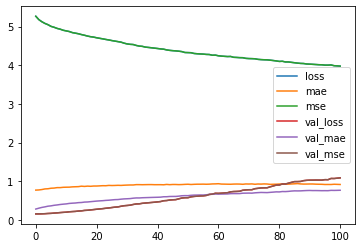

In [45]:
losses = pd.DataFrame(model.history.history)
losses.plot() # Plot the loss

## Model Testing


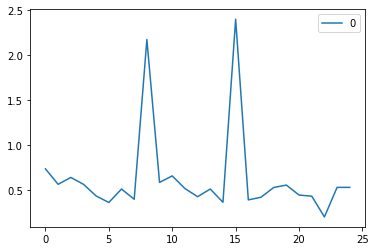

In [46]:
# Tesing the Model based on values from training X = Time , Y = Predicted temperature
testmodel = pd.DataFrame(model.predict(normed_test))
testmodel.plot()

In [48]:
# Predict what the TVOC will be after x amount of days
howmany = 1 # 10 days
answer = model.predict([normed_test[0:(howmany % len(normed_test))]])
print(f"The tvoc would be {answer.mean()} ppm after {howmany}")

The tvoc would be 0.7392183542251587 ppm after 1
